## and why domain expertise matters in machine learning...

Recently, my colleague [Prof. Michael Pyrcz](https://www.pge.utexas.edu/facultystaff/faculty-directory/pyrcz) ([@GeostatsGuy](https://twitter.com/GeostatsGuy)) and myself hosted a [data science hackathon](https://github.com/PGEHackathon/PGEHackathon) open to students at [The University of Texas at Austin](https://utexas.edu) with support from [The Hildebrand Department of Petroleum and Geosystems Engineering](https://pge.utexas.edu).  Given the COVID pandemic, we hosted the event virtually over two weekends in April 2021.  The first weekend consisted of a [workshop](https://github.com/PGEHackathon/workshop) followed by an explanation of the [problem dataset](https://github.com/PGEHackathon/data), then the students broke into teams and worked on their solutions that were ultimately submitted for scoring, code review, and presentation judging by a panel of industry experts the following weekend.  

This was a really fun experience for me personally and the feedback has been incredible from all involved. Given that I have been teaching data science skills and challenging students in my classes with difficult coding exercises for years, it was great to see them showcase their capabilities.  

I'd encourage you to take a look at the detailed problem statement and datasets linked to above, but briefly, the challenge was: given petrophysical data from well logs and spatial maps interpreted from seismic on 73 oil wells that have been in production for some time, predict the cumulative 3 year production for 10 new wells recently drilled, and having well log data, but not yet put into production.  In addition to their "best estimate" the students where asked to provide 100 additional realizations such that an uncertainty model could be evaluated.  The objective scoring consisted of comparisons of the mean squared error with respect to their "best estimate" and the true 3 year production (which we know, but was withheld from the students) as well as a scoring of their uncertainty model with a "goodness measure" proposed by Deutsch (1996).

I thought it would be a fun exercise to consider what I might have done to complete this challenge myself.  In the spirit of the hackathon, I'll limit my time working on the project to what I can accomplish in a single day.  Of course, since I am already familiar with the dataset, I have a head start over the teams in the competition who generally spent a few hours just investigating the data the first day.  But given my short timeline, I won't be training any complicated neural network architectures or really any complicated machine learning models at all. I want to see how I can use my domain expertise to engineer meaningful features to get an answer quickly.  I also have a surprise in store with respect to how I handled the uncertainty model.  So let's get started...

## Feature Imputation

First, like all work in Python, I'll start with the module imports used during this work.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
from scipy.optimize import curve_fit
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import (PolynomialFeatures, MaxAbsScaler, 
                                   MinMaxScaler, StandardScaler, RobustScaler)
from sklearn.linear_model import LinearRegression, ElasticNet 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_percentage_error
sns.set(rc={'text.usetex' : True})

And I'll read in the well log datasets from both the wells that have been in production as well as what we call the *preproduction* wells, i.e. those we are trying to predict the cumulative production for after 3 years.

In [2]:
production_wells_df = pd.read_csv('wellbore_data_producer_wells.csv', 
                                  index_col='Well_ID')
preproduction_wells_df = pd.read_csv('wellbore_data_preproduction_well.csv', 
                                     index_col='Well_ID')

Now we'll combine those two dataframes into a single dataframe.

In [3]:
wells_df = pd.concat([production_wells_df, preproduction_wells_df])
wells_df.head()

X, m  Y, m  Depth, m  Porosity, fraction  Permeability, mD  \
Well_ID                                                                 
Well_no_1  7325  7175    3052.8             0.13330               NaN   
Well_no_1  7325  7175    3053.3             0.13865               NaN   
Well_no_1  7325  7175    3053.8             0.14638               NaN   
Well_no_1  7325  7175    3054.3                 NaN               NaN   
Well_no_1  7325  7175    3054.8             0.14993               NaN   

           Acoustic Impedance, kg/s-m^2 Rock facies  Density, g/cm3  \
Well_ID                                                               
Well_no_1                   6981171.853   Sandstone        2.280137   
Well_no_1                   7234748.871   Sandstone        2.135061   
Well_no_1                   7157383.755   Sandstone        1.991045   
Well_no_1                           NaN   Sandstone        1.694242   
Well_no_1                           NaN   Sandstone        1.664371   

           Compressible velocity, m/s  Youngs modulus, GPa  \
Well_ID                                                      
Well_no_1                 3106.544655            24.721555   
Well_no_1                 4003.697087            23.360728   
Well_no_1                 3462.569030            28.232152   
Well_no_1                 3836.960702            29.220132   
Well_no_1                 3919.585777                  NaN   

           Shear velocity, m/s  Shear modulus, GPa  
Well_ID                                             
Well_no_1          1690.417133            7.304717  
Well_no_1          1573.847967            5.202120  
Well_no_1          1636.279139                 NaN  
Well_no_1          1613.043048            5.074763  
Well_no_1          1636.846284            5.277834

And inspect some overall statistics on the dataset.

In [4]:
wells_df.describe().T

count          mean            std  \
X, m                          1660.0  4.573795e+03    1982.122873   
Y, m                          1660.0  5.618373e+03    2284.982172   
Depth, m                      1660.0  3.055563e+03       4.282596   
Porosity, fraction            1444.0  1.278649e-01       0.036297   
Permeability, mD               332.0  1.140680e+02      81.300030   
Acoustic Impedance, kg/s-m^2  1544.0  7.323882e+06  312125.112401   
Density, g/cm3                1411.0  2.050372e+00       0.414102   
Compressible velocity, m/s    1444.0  3.688528e+03     724.061269   
Youngs modulus, GPa           1428.0  2.731047e+01       5.454678   
Shear velocity, m/s           1444.0  1.675224e+03      99.491202   
Shear modulus, GPa            1461.0  5.759466e+00       1.501610   

                                       min           25%           50%  \
X, m                          1.175000e+03  2.975000e+03  4.275000e+03   
Y, m                          7.750000e+02  3.975000e+03  5.675000e+03   
Depth, m                      3.045620e+03  3.052505e+03  3.055550e+03   
Porosity, fraction            4.027000e-02  1.138025e-01  1.376300e-01   
Permeability, mD              2.214604e+00  5.165015e+01  9.479379e+01   
Acoustic Impedance, kg/s-m^2  6.559277e+06  7.105710e+06  7.271181e+06   
Density, g/cm3                1.421943e+00  1.734559e+00  1.988778e+00   
Compressible velocity, m/s    1.661828e+03  3.172568e+03  3.663243e+03   
Youngs modulus, GPa           1.320513e+01  2.343858e+01  2.661773e+01   
Shear velocity, m/s           1.307887e+03  1.608163e+03  1.674237e+03   
Shear modulus, GPa            1.650985e+00  4.762268e+00  5.642379e+00   

                                       75%           max  
X, m                          6.225000e+03  9.025000e+03  
Y, m                          7.525000e+03  9.775000e+03  
Depth, m                      3.058573e+03  3.066300e+03  
Porosity, fraction            1.526325e-01  1.889100e-01  
Permeability, mD              1.558035e+02  4.892194e+02  
Acoustic Impedance, kg/s-m^2  7.502261e+06  8.249272e+06  
Density, g/cm3                2.230457e+00  3.530373e+00  
Compressible velocity, m/s    4.215650e+03  6.179653e+03  
Youngs modulus, GPa           3.092854e+01  4.812329e+01  
Shear velocity, m/s           1.744162e+03  1.989829e+03  
Shear modulus, GPa            6.609150e+00  1.182004e+01

We can see that there is quite a bit of missing data.  Of particular concern is the large amount of missing permeabilities as this will be one of the strongest indicators of production.  So our first task is going to be to impute the missing features, especially working toward a good model for permeability.  To start, let's plot some of the provided map data.  Here we are showing the spatial distributions of percentage facies in the reservoir.  There is a fault in the reservoir which we only know the location of, but no other information.  The white circles represent wells we have production for, the red circles are wells we are trying to predict production.  The fault is indicated by the red line.  

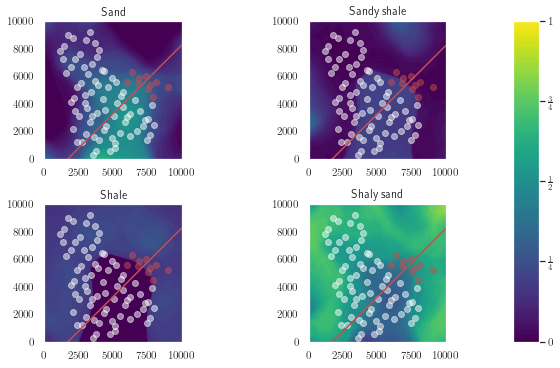

In [5]:
production_well_locations = \
    (production_wells_df[['X, m', 'Y, m']]
     .groupby(production_wells_df.index)
     .mean())
preproduction_well_locations = \
    (preproduction_wells_df[['X, m', 'Y, m']]
     .groupby(preproduction_wells_df.index)
     .mean())
px = production_well_locations['X, m'].to_numpy()[::1]
py = -production_well_locations['Y, m'].to_numpy() + 10000
ppx = preproduction_well_locations['X, m'].to_numpy()[::1]
ppy = -preproduction_well_locations['Y, m'].to_numpy() + 10000
fx = np.linspace(0, 1e4, num=5)
fy = fx - 1750 
fig = plt.figure(constrained_layout=True, figsize=(8,5))
ax = fig.subplot_mosaic(
    [['sand',  'sandy shale', 'colorbar'],
     ['shale', 'shaly sand',  'colorbar']],
     gridspec_kw={"width_ratios": [1, 1, 0.1]})
cmap = cm.get_cmap('viridis', 100)
bounds = np.linspace(0,1.0,num=100)
vals = bounds#[:-1]
norm = colors.BoundaryNorm(bounds, cmap.N)
ax['sand'].imshow(np.load('2d_sand_propotion.npy'), cmap=cmap, norm=norm, 
                  extent=[0, 10000, 0, 10000])
ax['sand'].scatter(px, py, color='w', marker='o', alpha=0.5)
ax['sand'].scatter(ppx, ppy, color='r', marker='o', alpha=0.5)
ax['sand'].plot(fx, fy, color='r')
ax['sand'].set_ylim([0,1e4])
ax['sand'].set_title('Sand')
ax['sand'].set_aspect(1)
ax['sand'].grid(None)
ax['sandy shale'].imshow(np.load('2d_sandy_shale_propotion.npy'), cmap=cmap, 
                         norm=norm, extent=[0, 10000, 0, 10000])
ax['sandy shale'].scatter(px, py, color='w', marker='o', alpha=0.5)
ax['sandy shale'].scatter(ppx, ppy, color='r', marker='o', alpha=0.5)
ax['sandy shale'].plot(fx, fy, color='r')
ax['sandy shale'].set_ylim([0,1e4])
ax['sandy shale'].set_title('Sandy shale')
ax['sandy shale'].set_aspect(1)
ax['sandy shale'].grid(None)
ax['shale'].imshow(np.load('2d_shale_propotion.npy'), cmap=cmap, norm=norm, 
                   extent=[0, 10000, 0, 10000])
ax['shale'].scatter(px, py, color='w', marker='o', alpha=0.5)
ax['shale'].scatter(ppx, ppy, color='r', marker='o', alpha=0.5)
ax['shale'].plot(fx, fy, color='r')
ax['shale'].set_ylim([0,1e4])
ax['shale'].set_title('Shale')
ax['shale'].set_aspect(1)
ax['shale'].grid(None)
im = ax['shaly sand'].imshow(np.load('2d_shaly_sand_propotion.npy'), cmap=cmap, 
                             norm=norm, extent=[0, 10000, 0, 10000])
ax['shaly sand'].scatter(px, py, color='w', marker='o', alpha=0.5)
ax['shaly sand'].scatter(ppx, ppy, color='r', marker='o', alpha=0.5)
ax['shaly sand'].plot(fx, fy, color='r')
ax['shaly sand'].set_ylim([0,1e4])
ax['shaly sand'].set_title('Shaly sand')
ax['shaly sand'].set_aspect(1)
ax['shaly sand'].grid(None)
cbar = fig.colorbar(im, cax=ax['colorbar'], boundaries=bounds, values=vals);
cbar.set_ticks([0.0, 0.25, 0.5, 0.75, 1.0])
cbar.set_ticklabels([r'$0$', r'$\frac{1}{4}$', r'$\frac{1}{2}$', 
                     r'$\frac{3}{4}$', r'$1$'])

It doesn't look like the fault produces any offset or discontinuity in the spatial facies information, that's good news, so we'll proceed with imputing the missing facies information using spatial location information.  First, we'll subset the dataframe and replace the string labels for facies with numerical ones, so 0 will indicated Sandstone, 1 will indicate Sandy shale, and so on...

In [6]:
facies_df = (wells_df[['X, m', 'Y, m', 'Depth, m', 'Rock facies']]
             .replace({'Sandstone': 0, 
                       'Sandy shale': 1,
                       'Shale': 2,
                       'Shaly sandstone': 3})
            )
missing_facies = facies_df['Rock facies'].isnull()
facies_df[~missing_facies].head()

X, m  Y, m  Depth, m  Rock facies
Well_ID                                     
Well_no_1  7325  7175    3052.8          0.0
Well_no_1  7325  7175    3053.3          0.0
Well_no_1  7325  7175    3053.8          0.0
Well_no_1  7325  7175    3054.3          0.0
Well_no_1  7325  7175    3054.8          0.0

Now we'll build a k-nearest neighbors classifier, do a little hyperparameter tuning with [scikit-learn](https://scikit-learn.org/stable/index.html)'s builtin [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). 

In [7]:
parameters = {'weights': ('uniform', 'distance'), 
              'n_neighbors':[4, 6, 8, 10]}
knn = KNeighborsClassifier()
gcv = GridSearchCV(knn, parameters, cv=KFold(random_state=2, shuffle=True))
gcv.fit(facies_df.loc[~missing_facies, 'X, m':'Depth, m'], 
        facies_df.loc[~missing_facies, 'Rock facies'])
gcv.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

Using the hyperparameter settings above, we can now predict (and impute) the missing facies values.

In [8]:
facies_df.loc[missing_facies, 'Rock facies'] = \
    gcv.predict(facies_df.loc[missing_facies, 'X, m':'Depth, m'])
wells_df['Rock facies'] = facies_df['Rock facies'].astype('int')
wells_df.describe().T.loc[['X, m', 'Y, m', 'Rock facies']]

count         mean          std     min     25%     50%     75%  \
X, m         1660.0  4573.795181  1982.122873  1175.0  2975.0  4275.0  6225.0   
Y, m         1660.0  5618.373494  2284.982172   775.0  3975.0  5675.0  7525.0   
Rock facies  1660.0     1.227711     1.335725     0.0     0.0     1.0     3.0   

                max  
X, m         9025.0  
Y, m         9775.0  
Rock facies     3.0

Given that we'd expect rocks of the same facies to have a similar density and acoustic impedance, we'll impute those missing features with the averages from each facies.

In [9]:
wells_df['Density, g/cm3'] = \
    (wells_df.groupby('Rock facies')['Density, g/cm3']
             .apply(lambda df: df.fillna(df.mean()))
             .reset_index()
             .set_index(['Well_ID'])
    )

wells_df['Acoustic Impedance, kg/s-m^2'] = \
    (wells_df.groupby('Rock facies')['Acoustic Impedance, kg/s-m^2']
             .apply(lambda df: df.fillna(df.mean()))
             .reset_index()
             .set_index(['Well_ID'])
    )

Now we'll subset the dataframe and use the features shown to impute the missing porosity values using polynomial regression.

In [10]:
missing_porosity = wells_df['Porosity, fraction'].isnull()
porosity_df = (wells_df.loc[:, 'X, m':'Density, g/cm3']
               .drop('Permeability, mD', axis=1))
porosity_df.head()

X, m  Y, m  Depth, m  Porosity, fraction  \
Well_ID                                               
Well_no_1  7325  7175    3052.8             0.13330   
Well_no_1  7325  7175    3053.3             0.13865   
Well_no_1  7325  7175    3053.8             0.14638   
Well_no_1  7325  7175    3054.3                 NaN   
Well_no_1  7325  7175    3054.8             0.14993   

           Acoustic Impedance, kg/s-m^2  Rock facies  Density, g/cm3  
Well_ID                                                               
Well_no_1                  6.981172e+06            0        2.280137  
Well_no_1                  7.234749e+06            0        2.135061  
Well_no_1                  7.157384e+06            0        1.991045  
Well_no_1                  7.124201e+06            0        1.694242  
Well_no_1                  7.124201e+06            0        1.664371

We'll setup a pipeline and use `GridSearchCV` again to find the best hyperparameters.

In [11]:
scalers = [MaxAbsScaler(), MinMaxScaler(), StandardScaler(), RobustScaler()]

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('poly', PolynomialFeatures()),
    ('reg', LinearRegression())
])

params = {
    'scaler': scalers,
    'poly__degree': [1, 2, 3],
    'pca__n_components': [1, 2, 3, 4, 5, 6],
}

gcv = GridSearchCV(pipe, params, cv=KFold(random_state=5, shuffle=True))
gcv.fit(porosity_df[~missing_porosity].drop('Porosity, fraction', axis=1), 
        porosity_df.loc[~missing_porosity, 'Porosity, fraction'])
gcv.best_params_

{'pca__n_components': 5, 'poly__degree': 2, 'scaler': MinMaxScaler()}

The best parameters are shown above.  Now we'll use this model to impute the missing porosity. 

In [12]:
porosity_df.loc[missing_porosity, 'Porosity, fraction'] = \
    gcv.predict(porosity_df[missing_porosity].drop('Porosity, fraction', axis=1))

Below we'll plot the imputed and given porosities.  Nothing looks too strange here, none of the imputed values are outliers with respect to the ranges of the given data.

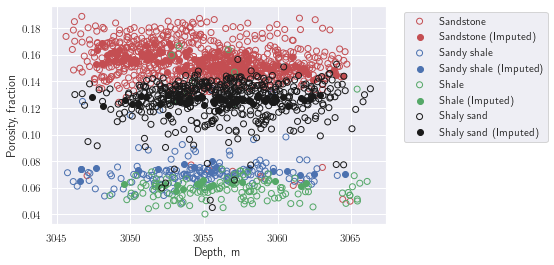

In [13]:
fig, ax = plt.subplots()
ax.scatter(porosity_df[~missing_porosity & 
                       (porosity_df['Rock facies'] == 0)]['Depth, m'], 
           porosity_df[~missing_porosity & 
                       (porosity_df['Rock facies'] == 0)]['Porosity, fraction'], 
           color='r', facecolors='none', label='Sandstone')
ax.scatter(porosity_df[missing_porosity & 
                       (porosity_df['Rock facies'] == 0)]['Depth, m'], 
           porosity_df[missing_porosity & 
                       (porosity_df['Rock facies'] == 0)]['Porosity, fraction'], 
           color='r', label='Sandstone (Imputed)')
ax.scatter(porosity_df[~missing_porosity & 
                       (porosity_df['Rock facies'] == 1)]['Depth, m'], 
           porosity_df[~missing_porosity & 
                       (porosity_df['Rock facies'] == 1)]['Porosity, fraction'], 
           color='b', facecolors='none', label='Sandy shale')
ax.scatter(porosity_df[missing_porosity & 
                       (porosity_df['Rock facies'] == 1)]['Depth, m'], 
           porosity_df[missing_porosity & 
                       (porosity_df['Rock facies'] == 1)]['Porosity, fraction'], 
           color='b', label='Sandy shale (Imputed)')
ax.scatter(porosity_df[~missing_porosity & 
                       (porosity_df['Rock facies'] == 2)]['Depth, m'], 
           porosity_df[~missing_porosity & 
                       (porosity_df['Rock facies'] == 2)]['Porosity, fraction'], 
           color='g', facecolors='none', label='Shale')
ax.scatter(porosity_df[missing_porosity & 
                       (porosity_df['Rock facies'] == 2)]['Depth, m'], 
           porosity_df[missing_porosity & 
                       (porosity_df['Rock facies'] == 2)]['Porosity, fraction'], 
           color='g', label='Shale (Imputed)')
ax.scatter(porosity_df[~missing_porosity & 
                       (porosity_df['Rock facies'] == 3)]['Depth, m'], 
           porosity_df[~missing_porosity & 
                       (porosity_df['Rock facies'] == 3)]['Porosity, fraction'], 
           color='k', facecolors='none', label='Shaly sand')
ax.scatter(porosity_df[missing_porosity & 
                       (porosity_df['Rock facies'] == 3)]['Depth, m'], 
           porosity_df[missing_porosity & 
                       (porosity_df['Rock facies'] == 3)]['Porosity, fraction'], 
           color='k', label='Shaly sand (Imputed)')
ax.set_xlabel('Depth, m')
ax.set_ylabel('Porosity, fraction')
ax.legend(bbox_to_anchor=(1.5, 1), loc='upper right', ncol=1);

We can also look at the distribution of the imputed porosities and compare to the given values.  The imputation preserves the bimodal distribution of the original data.

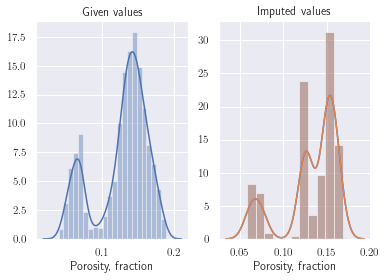

In [14]:
fig, ax = plt.subplots(1, 2)
sns.distplot(porosity_df.loc[~missing_porosity, 'Porosity, fraction'], ax=ax[0])
ax[0].set_title('Given values')
sns.distplot(porosity_df.loc[missing_porosity, 'Porosity, fraction'], ax=ax[1]);
sns.distplot(porosity_df.loc[missing_porosity, 'Porosity, fraction'], ax=ax[1]);
ax[1].set_title('Imputed values');

Now we'll add this imputed data to our `wells_df`.

In [15]:
wells_df['Porosity, fraction'] =  porosity_df['Porosity, fraction']

To impute the missing permeabilities, we'll use some knowledge of petrophysics to do a little feature engineering.  There is a widely used correlation between porosity and permeability called the Kozeny-Carmen relationship which models permeability as

$$
\kappa \sim \frac{\phi^3}{(1-\phi)^2}
$$

where $\kappa$ is the permeability and $\phi$ is the porosity.  We can quickly take a look at this relationship using [seaborn](https://seaborn.pydata.org/)'s builtin [`regplot`](https://seaborn.pydata.org/generated/seaborn.regplot.html?highlight=regplot#seaborn.regplot) function, i.e.

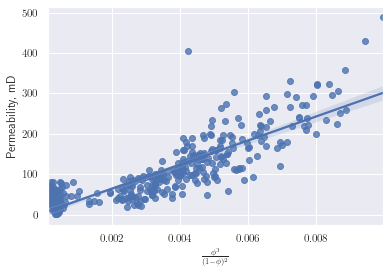

In [16]:
missing_perms = wells_df['Permeability, mD'].isnull()
ϕ = wells_df.loc[~missing_perms, 'Porosity, fraction'].to_numpy()
fig, ax = plt.subplots()
sns.regplot(ϕ ** 3 / (1 - ϕ) ** 2, 
            wells_df.loc[~missing_perms, 'Permeability, mD'], ax=ax);
ax.set_xlabel(r'$\frac{\phi^3}{(1 - \phi)^2}$');

While not the best model, we can use this data to condition our more complex prediction to come.  First we find the slope and intercept of the blue line above.

In [17]:
fphi = lambda ϕ, m, kappa0: m * ϕ ** 3 / (1 - ϕ) ** 2 + kappa0
popt, _ = curve_fit(fphi, ϕ, wells_df.loc[~missing_perms, 'Permeability, mD'])

Now we'll use the model to create a feature we'll call `'KC permeability, mD'`.

In [18]:
perm_df = wells_df.loc[:, 'X, m':'Density, g/cm3']
perm_df['KC permeability, mD'] = fphi(wells_df['Porosity, fraction'], 
                                      popt[0], popt[1])

Using the data show above, we'll build a model to impute the missing permeabilities.  Again, using `GridSearchCV` to hyperparameter tune, we have

In [19]:
scalers = [MaxAbsScaler(), MinMaxScaler(), StandardScaler(), RobustScaler()]

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('poly', PolynomialFeatures()),
    ('reg', LinearRegression())
])

params = {
    'scaler': scalers,
    'poly__degree': [2, 3, 4],
    'pca__n_components': [1, 2, 3, 4, 5, 6, 7],
}

gcv = GridSearchCV(pipe, params, cv=KFold(random_state=5, shuffle=True))
gcv.fit(perm_df[~missing_perms].drop('Permeability, mD', axis=1), 
        perm_df.loc[~missing_perms, 'Permeability, mD'])
gcv.best_params_

{'pca__n_components': 4, 'poly__degree': 2, 'scaler': RobustScaler()}

With these parameters, we can predict the missing permeabilities.

In [20]:
perm_df.loc[missing_perms, 'Permeability, mD'] = \
    gcv.predict(perm_df[missing_perms].drop('Permeability, mD', axis=1))

Visualizing the results of the prediction against the given data, this model appears to perform well.

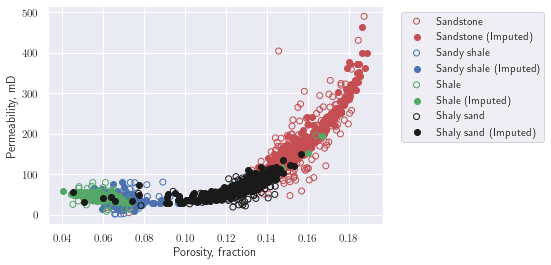

In [21]:
fig, ax = plt.subplots()
ax.scatter(perm_df[~missing_perms & 
                   (perm_df['Rock facies'] == 0)]['Porosity, fraction'], 
           perm_df[~missing_perms & 
                   (perm_df['Rock facies'] == 0)]['Permeability, mD'], 
           color='r', facecolors='none', label='Sandstone')
ax.scatter(perm_df[missing_perms & 
                   (perm_df['Rock facies'] == 0)]['Porosity, fraction'], 
           perm_df[missing_perms & 
                   (perm_df['Rock facies'] == 0)]['Permeability, mD'], 
           color='r', label='Sandstone (Imputed)')
ax.scatter(perm_df[~missing_perms & 
                   (perm_df['Rock facies'] == 1)]['Porosity, fraction'], 
           perm_df[~missing_perms & 
                   (perm_df['Rock facies'] == 1)]['Permeability, mD'], 
           color='b', facecolors='none', label='Sandy shale')
ax.scatter(perm_df[missing_perms & 
                   (perm_df['Rock facies'] == 1)]['Porosity, fraction'], 
           perm_df[missing_perms & 
                   (perm_df['Rock facies'] == 1)]['Permeability, mD'], 
           color='b', label='Sandy shale (Imputed)')
ax.scatter(perm_df[~missing_perms & 
                   (perm_df['Rock facies'] == 2)]['Porosity, fraction'], 
           perm_df[~missing_perms & 
                   (perm_df['Rock facies'] == 2)]['Permeability, mD'], 
           color='g', facecolors='none', label='Shale')
ax.scatter(perm_df[missing_perms & 
                   (perm_df['Rock facies'] == 2)]['Porosity, fraction'], 
           perm_df[missing_perms & 
                   (perm_df['Rock facies'] == 2)]['Permeability, mD'], 
           color='g', label='Shale (Imputed)')
ax.scatter(perm_df[~missing_perms & 
                   (perm_df['Rock facies'] == 3)]['Porosity, fraction'], 
           perm_df[~missing_perms & 
                   (perm_df['Rock facies'] == 3)]['Permeability, mD'], 
           color='k', facecolors='none', label='Shaly sand')
ax.scatter(perm_df[missing_perms & 
                   (perm_df['Rock facies'] == 3)]['Porosity, fraction'], 
           perm_df[missing_perms & 
                   (perm_df['Rock facies'] == 3)]['Permeability, mD'], 
           color='k', label='Shaly sand (Imputed)')
ax.set_xlabel('Porosity, fraction')
ax.set_ylabel('Permeability, mD')
ax.legend(bbox_to_anchor=(1.5, 1), loc='upper right', ncol=1);

The `'KC permeability, mD'` is redundant now, so we'll drop it from the dataframe.

In [22]:
perm_df.drop('KC permeability, mD', axis=1, inplace=True)

## Feature engineering

Since the fault runs right through both the produced wells and the wells we are trying to predict production for, let's engineer a few features related to the fault.  First we'll engineer a feature we'll call `'Distance to fault'` which computes the perpendicular distance to the fault.  Also, we don't know if the fault compartmentalizes the reservoir in any way, so we'll also create a feature called `'left/right fault'` to indicate which side of the fault a well lies.

In [23]:
perm_df['Distance to fault'] = np.sqrt((perm_df['X, m'] + perm_df['Y, m'] - 11750) ** 2) / np.sqrt(2)
perm_df['left/right fault'] = np.sign(perm_df['X, m'] * (-11750) - (perm_df['Y, m'] - 11750) * (11750))

Because all of the prediction wells are "near" the fault, we'll create another boolean feature that gives some importance to wells near the fault.  We'll define "near" as any well that is closer than the mean preproduction (i.e. prediction) well distance from the fault.

In [24]:
preproduction_wells = perm_df.index.isin(preproduction_wells_df
                                         .index.to_numpy())
max_distance = perm_df.loc[preproduction_wells, 'Distance to fault'].mean()
perm_df['close to fault'] = np.where(
    perm_df['Distance to fault'] < max_distance, 1, 0)

Give that we anticipate wells that are "similar" to have "similar" production, we'll use `KMeans` clustering to find similar wells in our dataframe

In [25]:
scalers = [MaxAbsScaler(), MinMaxScaler(), StandardScaler(), RobustScaler()]

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('cluster', KMeans())
])

params = {
    'scaler': scalers,
    'cluster__n_clusters': [10, 12, 14],
}

gcv = GridSearchCV(pipe, params, cv=KFold(random_state=3, shuffle=True))
gcv.fit(perm_df.loc[~preproduction_wells])
gcv.best_params_

{'cluster__n_clusters': 14, 'scaler': MaxAbsScaler()}

And use the model to predict which cluster the preproduction wells would fall into.

In [26]:
perm_df['Cluster'] = gcv.predict(perm_df)

Now we'll read in the production histories and merge them with our working dataframe.

In [27]:
production_history_df = pd.read_csv('production_history.csv', 
                                    index_col='Well_ID')
production_df = perm_df.merge(production_history_df, 
                              how='left', 
                              left_index=True, 
                              right_index=True)
production_df.head()

X, m  Y, m  Depth, m  Porosity, fraction  Permeability, mD  \
Well_ID                                                                 
Well_no_1  7325  7175    3052.8            0.133300         84.088999   
Well_no_1  7325  7175    3053.3            0.138650         94.107409   
Well_no_1  7325  7175    3053.8            0.146380        117.272922   
Well_no_1  7325  7175    3054.3            0.156552        151.990789   
Well_no_1  7325  7175    3054.8            0.149930        124.505979   

           Acoustic Impedance, kg/s-m^2  Rock facies  Density, g/cm3  \
Well_ID                                                                
Well_no_1                  6.981172e+06            0        2.280137   
Well_no_1                  7.234749e+06            0        2.135061   
Well_no_1                  7.157384e+06            0        1.991045   
Well_no_1                  7.124201e+06            0        1.694242   
Well_no_1                  7.124201e+06            0        1.664371   

           Distance to fault  left/right fault  close to fault  Cluster  \
Well_ID                                                                   
Well_no_1        1944.543648                -1               0        4   
Well_no_1        1944.543648                -1               0        4   
Well_no_1        1944.543648                -1               0        4   
Well_no_1        1944.543648                -1               0        4   
Well_no_1        1944.543648                -1               0        4   

           Cumulative oil production (1 yr), MSTB  \
Well_ID                                             
Well_no_1                                  450.98   
Well_no_1                                  450.98   
Well_no_1                                  450.98   
Well_no_1                                  450.98   
Well_no_1                                  450.98   

           Cumulative oil production (2 yr), MSTB  \
Well_ID                                             
Well_no_1                                   684.2   
Well_no_1                                   684.2   
Well_no_1                                   684.2   
Well_no_1                                   684.2   
Well_no_1                                   684.2   

           Cumulative oil production (3 yr), MSTB  \
Well_ID                                             
Well_no_1                                  847.33   
Well_no_1                                  847.33   
Well_no_1                                  847.33   
Well_no_1                                  847.33   
Well_no_1                                  847.33   

           Cumulative Water production (1 yr), MSTB  \
Well_ID                                               
Well_no_1                                    494.89   
Well_no_1                                    494.89   
Well_no_1                                    494.89   
Well_no_1                                    494.89   
Well_no_1                                    494.89   

           Cumulative Water production (2 yr), MSTB  \
Well_ID                                               
Well_no_1                                    1236.4   
Well_no_1                                    1236.4   
Well_no_1                                    1236.4   
Well_no_1                                    1236.4   
Well_no_1                                    1236.4   

           Cumulative Water production (3 yr), MSTB  
Well_ID                                              
Well_no_1                                    2108.7  
Well_no_1                                    2108.7  
Well_no_1                                    2108.7  
Well_no_1                                    2108.7  
Well_no_1                                    2108.7

Now we'll compute the average 1, 2, and 3 year productions for each cluster and assign a new feature with this average value as the expected average production at each well location.

In [28]:
avg_production_df = (production_df
                     .groupby('Cluster')
                     .mean()
                     .loc[:, 'Cumulative oil production (1 yr), MSTB' \
                            :'Cumulative Water production (3 yr), MSTB']
                     .reset_index()
                     .rename(columns={'Cumulative oil production (1 yr), ' \
                                      'MSTB':'Avg. oil prod (1 yr)',
                                      'Cumulative oil production (2 yr), ' \
                                      'MSTB':'Avg. oil prod (2 yr)',
                                      'Cumulative oil production (3 yr), ' \
                                      'MSTB':'Avg. oil prod (3 yr)',
                                      'Cumulative Water production (1 yr), ' \
                                      'MSTB':'Avg. water prod (1 yr)',
                                      'Cumulative Water production (2 yr), ' \
                                      'MSTB':'Avg. water prod (2 yr)',
                                      'Cumulative Water production (3 yr), ' \
                                      'MSTB':'Avg. water prod (3 yr)'})
                    )

Merging these averaged production values into our working dataframe, we have the final dataframe which we'll use to make predictions with.

In [29]:
final_df = (production_df
            .reset_index()
            .merge(avg_production_df, 
                   how='left', 
                   on='Cluster')
            .set_index(['Well_ID'])
           )
final_df.head()

X, m  Y, m  Depth, m  Porosity, fraction  Permeability, mD  \
Well_ID                                                                 
Well_no_1  7325  7175    3052.8            0.133300         84.088999   
Well_no_1  7325  7175    3053.3            0.138650         94.107409   
Well_no_1  7325  7175    3053.8            0.146380        117.272922   
Well_no_1  7325  7175    3054.3            0.156552        151.990789   
Well_no_1  7325  7175    3054.8            0.149930        124.505979   

           Acoustic Impedance, kg/s-m^2  Rock facies  Density, g/cm3  \
Well_ID                                                                
Well_no_1                  6.981172e+06            0        2.280137   
Well_no_1                  7.234749e+06            0        2.135061   
Well_no_1                  7.157384e+06            0        1.991045   
Well_no_1                  7.124201e+06            0        1.694242   
Well_no_1                  7.124201e+06            0        1.664371   

           Distance to fault  left/right fault  ...  \
Well_ID                                         ...   
Well_no_1        1944.543648                -1  ...   
Well_no_1        1944.543648                -1  ...   
Well_no_1        1944.543648                -1  ...   
Well_no_1        1944.543648                -1  ...   
Well_no_1        1944.543648                -1  ...   

           Cumulative oil production (3 yr), MSTB  \
Well_ID                                             
Well_no_1                                  847.33   
Well_no_1                                  847.33   
Well_no_1                                  847.33   
Well_no_1                                  847.33   
Well_no_1                                  847.33   

           Cumulative Water production (1 yr), MSTB  \
Well_ID                                               
Well_no_1                                    494.89   
Well_no_1                                    494.89   
Well_no_1                                    494.89   
Well_no_1                                    494.89   
Well_no_1                                    494.89   

           Cumulative Water production (2 yr), MSTB  \
Well_ID                                               
Well_no_1                                    1236.4   
Well_no_1                                    1236.4   
Well_no_1                                    1236.4   
Well_no_1                                    1236.4   
Well_no_1                                    1236.4   

           Cumulative Water production (3 yr), MSTB  Avg. oil prod (1 yr)  \
Well_ID                                                                     
Well_no_1                                    2108.7            510.514519   
Well_no_1                                    2108.7            510.514519   
Well_no_1                                    2108.7            510.514519   
Well_no_1                                    2108.7            510.514519   
Well_no_1                                    2108.7            510.514519   

           Avg. oil prod (2 yr)  Avg. oil prod (3 yr)  Avg. water prod (1 yr)  \
Well_ID                                                                         
Well_no_1             795.43159           1000.623598              562.638577   
Well_no_1             795.43159           1000.623598              562.638577   
Well_no_1             795.43159           1000.623598              562.638577   
Well_no_1             795.43159           1000.623598              562.638577   
Well_no_1             795.43159           1000.623598              562.638577   

           Avg. water prod (2 yr)  Avg. water prod (3 yr)  
Well_ID                                                    
Well_no_1             1375.202887             2333.438494  
Well_no_1             1375.202887             2333.438494  
Well_no_1             1375.202887             2333.438494  
Well_no_1             1375.202887             2333.43849

## Predictions

In order to hyperparameter tune our forthcoming models, we're going to use the "goodness" measure of Deutsch, 1996, i.e.

$$
\mbox{goodness} = 1 - \int_0^1 \left(2 a(p) - 2 \right) \left(\overline{\xi(p)} - p \right) \mathrm{d}p
$$

in addition to the `mean_absolute_percentage_error` from scikit-learn to score our models.  The idea will be to use the `BaggingRegressor` to create an ensemble of models that we average over to create our "best estimate" as well using each individual estimator as a realization for our uncertainty model.  We'll score our model over each fold in the cross-validation using `GridSearchCV`.  Credit goes to [Honggeun Jo](https://github.com/whghdrms) for creating the original version of this function which I only slightly modified here.

In [30]:
def goodness_score(y_true, y_realizations):
    
    goodness_score_array = []
    # Define upper/lower boundary of "within-percentile" ranges
    list_percentile_lower = 50 - 5 * np.arange(0, 11, dtype=np.int32)   
    list_percentile_upper = 50 + 5 * np.arange(0, 11, dtype=np.int32)

    for i in range(11):     # 0%, 10%, 20%, 30%, ... 100% percentiles ranges
        num_within = 0      # Counts for predictions within the range
        for (j, realization) in enumerate(y_realizations.T): 
            min_ = np.percentile(realization, list_percentile_lower[i])
            max_ = np.percentile(realization, list_percentile_upper[i])
            if y_true[j] > min_ and y_true[j] < max_:
                num_within += 1
        goodness_score_array.append(num_within)

    goodness_score_upNdown = (np.array(goodness_score_array) - 
                              np.arange(0,11, dtype=np.double))
    a_interval_index = [1 if goodness_score_array[i+1] >= i+1 
                        else 0 for i in range(10)]
    goodness_score_ = 1
    for i in range(10):
        if a_interval_index[i] == 1:
            goodness_score_ -= 0.5 * goodness_score_upNdown[i+1] / 45
        else:
            goodness_score_ -= -goodness_score_upNdown[i+1] / 55
    return np.abs(goodness_score_)

    
def scorer(estimator, X, y):
    mape = 1 - mean_absolute_percentage_error(y[:,-1], estimator.predict(X)[:, -1])
    
    pipe = estimator[:-1]
    Xt = pipe.transform(X)

    realizations = []
    features = estimator[-1].estimators_features_
    for (i, e) in enumerate(estimator[-1].estimators_): 
        realizations.append(e.predict(Xt[:, features[i]])[:, -1])
    realizations = np.array(realizations)
    
    goodness = goodness_score(y[:,-1], realizations)
    
    return 0.5 * mape + 0.5 * goodness 

Separating our predictor and response features labels.

In [31]:
response_features = ['Cumulative Water production (1 yr), MSTB', 
                     'Cumulative Water production (2 yr), MSTB',
                     'Cumulative Water production (3 yr), MSTB',
                     'Cumulative oil production (1 yr), MSTB',
                     'Cumulative oil production (2 yr), MSTB',
                     'Cumulative oil production (3 yr), MSTB'] 
predictor_features = final_df.columns[~final_df.columns
                                      .isin(response_features)].to_numpy()

Since there are several data samples from each well, but we are only asked to report our prediction for the entire well, there are several options on how to proceed.  This simplest is just to average all the samples over each well, we'll use this approach in the interest of time.

In [32]:
avg_final_df = final_df.groupby(final_df.index).mean()

Getting a boolean indexer for our training wells (the wells that have been in production).

In [33]:
train_wells = ~avg_final_df.index.isin(preproduction_wells_df.index)

Now we'll set up a pipeline and pass that to `GridSearchCV` for hyperparameter tuning.  I iterated this a few times to narrow down the final set of parameters to search, so that the final notebook/solution runs in a timely manner.  Here I'm using 7 folds in the k-fold cross-validation because that leaves about 10 wells in the test set, similar to the number we need to predict.

In [34]:
scalers = [MaxAbsScaler(), RobustScaler()]

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('poly', PolynomialFeatures()),
    ('bag', BaggingRegressor(base_estimator=LinearRegression(), 
                             n_estimators=100, n_jobs=-1, random_state=7)),
])

params = [{
    'scaler': scalers,
    'pca__n_components': [8, 9],
    'poly__degree': [1, 2],
    'bag__max_samples': [0.75, 1.0],
    'bag__max_features': [0.75, 1.0],
    'bag__bootstrap': [True, False],
    'bag__base_estimator': [LinearRegression()]
}]

gcv = GridSearchCV(pipe, params, scoring=scorer, 
                   cv=KFold(n_splits=7, shuffle=True, random_state=17)
)

gcv.fit(avg_final_df.loc[train_wells, predictor_features].to_numpy(), 
        avg_final_df.loc[train_wells, response_features].to_numpy())
print(gcv.best_score_)
gcv.best_params_

0.8432431728379238


{'bag__base_estimator': LinearRegression(),
 'bag__bootstrap': True,
 'bag__max_features': 0.75,
 'bag__max_samples': 0.75,
 'pca__n_components': 9,
 'poly__degree': 1,
 'scaler': MaxAbsScaler()}

The "best score" and final set of hyperparameters are shown above.  Now we'll write our best estimate and realizations to the solution file.

In [35]:
solution_df = pd.read_csv('solution.csv', index_col='Well_ID')
pipe = gcv.best_estimator_

#best estimate
solution_df['Prediction, MSTB'] = \
    pipe.predict(avg_final_df.loc[~train_wells, predictor_features])[:, -1]

#realizations
Xt = pipe[:-1].transform(avg_final_df.loc[~train_wells, predictor_features])

features = pipe[-1].estimators_features_
for (i, estimator) in enumerate(pipe[-1].estimators_): 
    pt = estimator.predict(Xt[:, features[i]])[:, -1]
    solution_df[f'R{i+1}, MSTB']  = pt
    
#write to file
solution_df.to_csv('solution.csv')

Submitting the solution file for scoring, we can generate the following plots.  First we have the accuracy plot which compares the predictions to the actual 3 yr. production for the 10 wells.

MSE: 24697.56


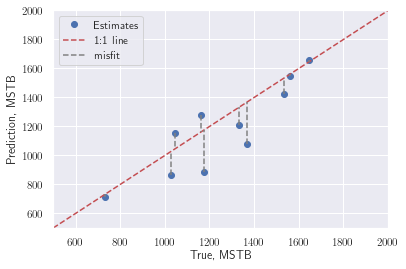

In [36]:
from score import (create_accuracy_plot_and_return_mse,
                   create_realizations_plots,
                   create_goodness_plot_and_return_goodness_score)

truth_data = np.load('True_for_predrill_3yr.npy')

mse = create_accuracy_plot_and_return_mse(solution_df, truth_data);
print(f'MSE: {mse}')

Below the uncertainty models are shown along with the true values.

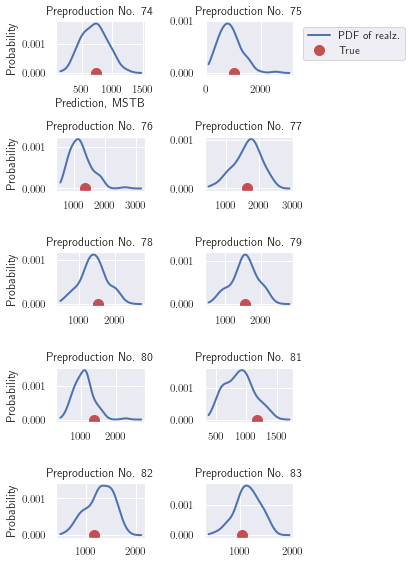

In [37]:
create_realizations_plots(solution_df, truth_data)

And finally the goodness plot.  The goodness measure we used in our `scorer` function above is related to the integral of the black dashed line with respect to the diagonal red line where the area below above the red line is weighted twice the area below.

Goodness: 0.856


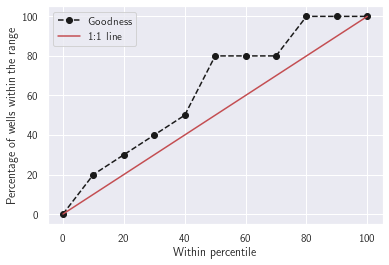

In [38]:
goodness = create_goodness_plot_and_return_goodness_score(solution_df, 
                                                          truth_data);
print(f'Goodness: {goodness}')

Finally, my rank in the competition among the other teams (note, this is only for the objective part of the scoring, in the actual Hackathon, there we had additional columns for code quality and presentations, therefore the final rankings of the other teams in this table does not reflect the actual final outcome of the competition).  Not bad for a days work!

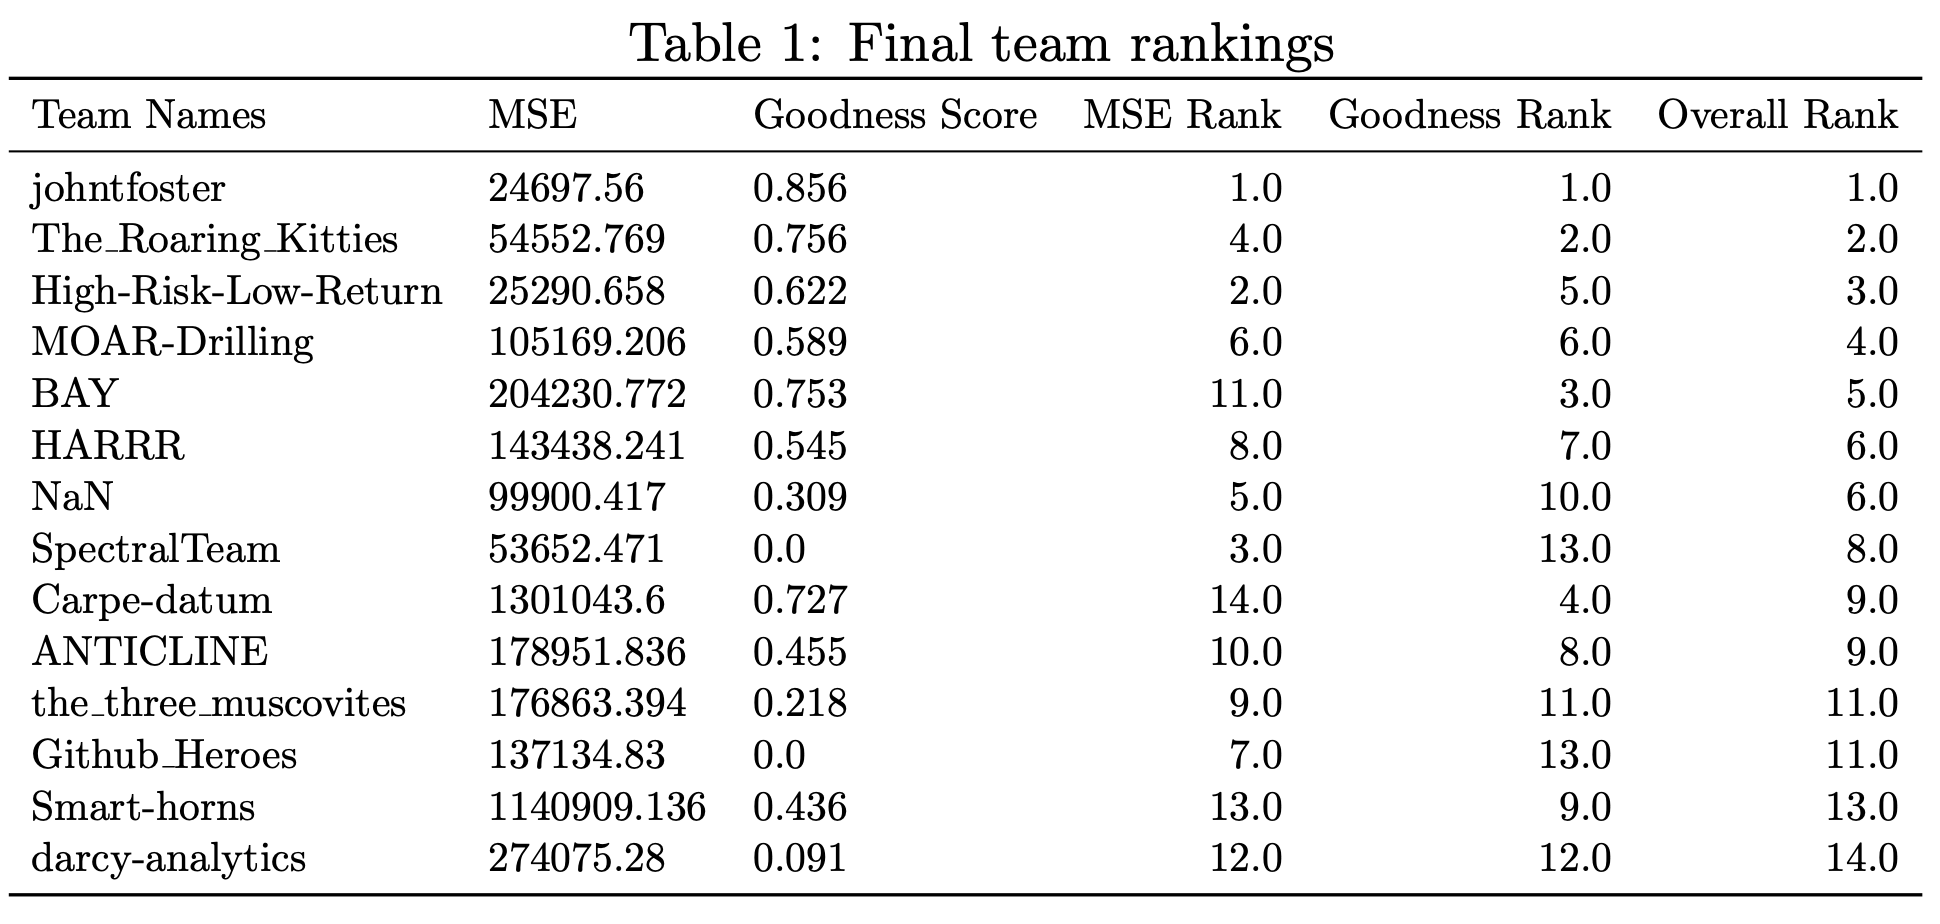

In [39]:
from IPython.display import Image
Image('results_table.png', width=500)

The final message here is that domain expertise, which leads to good imputation and feature engineering strategies is far more useful than fancy machine learning models.  Additionally, understanding exactly the quantities of interest you are looking for so that you evaluate (i.e. score) your models well. In the end, I "won" the competition with a linear regression model.